## Проект e-commerce
#### Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

#### Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

#### Файлы:

`olist_customers_datase.csv` — таблица с уникальными идентификаторами пользователей

- `customer_id` — позаказный идентификатор пользователя
- `customer_unique_id` —  уникальный идентификатор пользователя  (аналог номера паспорта)
- `customer_zip_code_prefix` —  почтовый индекс пользователя
- `customer_city` —  город доставки пользователя
- `customer_state` —  штат доставки пользователя

`olist_orders_dataset.csv1` —  таблица заказов

- `order_id` —  уникальный идентификатор заказа (номер чека)
- `customer_id` —  позаказный идентификатор пользователя
- `order_status` —  статус заказа
- `order_purchase_timestamp` —  время создания заказа
- `order_approved_at` —  время подтверждения оплаты заказа
- `order_delivered_carrier_date` —  время передачи заказа в логистическую службу
- `order_delivered_customer_date` —  время доставки заказа
- `order_estimated_delivery_date` —  обещанная дата доставки

`olist_order_items_dataset.csv` —  товарные позиции, входящие в заказы

- `order_id` —  уникальный идентификатор заказа (номер чека)
- `order_item_id` —  идентификатор товара внутри одного заказа
- `product_id` —  ид товара (аналог штрихкода)
- `seller_id` — ид производителя товара
- `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- `price` —  цена за единицу товара
- `freight_value` —  вес товара

Уникальные статусы заказов в таблице `olist_orders_dataset`:

- `created` —  создан
- `approved` —  подтверждён
- `invoiced` —  выставлен счёт
- `processing` —  в процессе сборки заказа
- `shipped` —  отгружен со склада
- `delivered` —  доставлен пользователю
- `unavailable` —  недоступен
- `canceled` —  отменён

---

## 0. EDA (exploratory data analysis)

---

>импортируем все нужные нам библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import warnings

>выгружаем данные

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')

>ищем ячейки с пустыми значениями в трех загруженных датафреймах

In [35]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [33]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [34]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

>как видим пропуски данных только в датафреме orders и только в ячейках показывающих даты перемещения груза, но это логично так как какой-то товар мог быть заказан, но еще не оплачен, не был передан в доставку, т.к. его отменили итд. Думаю тут удалять строки с пропущенными значениями смысла нет, это скорее даже испортит правильную картину

>теперь ищем повторяющиеся значения в наших датафремах

In [84]:
customers[customers.duplicated ()]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [85]:
orders[orders.duplicated ()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [86]:
items[items.duplicated ()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


>и как видим их нет, теперь когда мы провели предварительный анализ, можем переходить к заданию

---

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

---

>определим что такое "покупка", пусть покупкой мы будем считать только те заказы статус которых обозначен как delivered (доставлен пользователю)

>для этого смерджим customers и orders, для получения доступа ко всем нужным нам данным

In [4]:
customers_and_orders = customers.merge(orders, on = 'customer_id')

In [5]:
customers_and_orders.query('order_status == "delivered"') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id':'count'}) \
    .query('customer_id == 1') \
    .shape[0]

90557

>ответ. у нас есть 90 557 пользователей, которые совершили одну покупку

---

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

---

>оставляем только те заказы что были недоступны или отменены

In [6]:
orders_not_delivery = orders.query('order_status == ["canceled", "unavailable"]')
orders_not_delivery.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaN,NaN,2018-08-14 00:00:00
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaN,2018-02-22 00:00:00
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00


>переводим столбец order_purchase_timestamp в формат dt

In [7]:
warnings.filterwarnings('ignore')
orders_not_delivery['order_purchase_timestamp'] = pd.to_datetime(orders_not_delivery['order_purchase_timestamp'])

>добавляем столбцы month_order и year_order, где будет указан месяц и год в который был создан заказ

In [8]:
orders_not_delivery['month_order'] = orders_not_delivery.order_purchase_timestamp.dt.month
orders_not_delivery['year_order'] = orders_not_delivery.order_purchase_timestamp.dt.year

>теперь сделаем талицу в которой покажем кол-во недоставленных заказов, а после вынесем причины недоставленных заказов (canceled и unavailable) в отдельные столбцы, с помощью pivot

In [191]:
table_orders_not_delivery = orders_not_delivery.groupby(['year_order', 'month_order', 'order_status'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .pivot(index=['year_order', 'month_order'], columns='order_status', values='customer_id') \
    .reset_index() \
    .sort_values(['year_order', 'month_order']) \
    .fillna(0)
table_orders_not_delivery

order_status,year_order,month_order,canceled,unavailable
0,2016,9,2.0,0.0
1,2016,10,24.0,7.0
2,2017,1,3.0,10.0
3,2017,2,17.0,45.0
4,2017,3,33.0,32.0
5,2017,4,18.0,9.0
6,2017,5,29.0,31.0
7,2017,6,16.0,24.0
8,2017,7,28.0,52.0
9,2017,8,27.0,32.0


<Figure size 1152x1152 with 0 Axes>

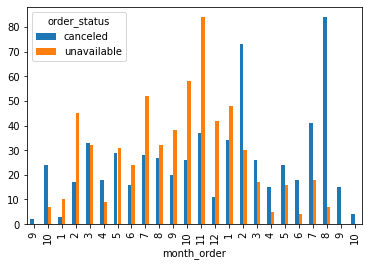

In [192]:
plt.figure(figsize=(16, 16))
table_orders_not_delivery[['month_order', 'canceled', 'unavailable']].plot.bar(x='month_order')

>найдем среднемесячное кол-во не доставленных заказов в разрезе статусов (canceled и unavailable)

In [189]:
mean_canceled = table_orders_not_delivery.canceled.mean().round(0)
mean_unavailable = table_orders_not_delivery.unavailable.mean().round(0)
print("В среднем каждый месяц не доставляется {} заказов по причине отмены (canceled) и {} заказов по причине недоступности (unavailable)".format(mean_canceled, mean_unavailable))

В среднем каждый месяц не доставляется 26.0 заказов по причине отмены (canceled) и 25.0 заказов по причине недоступности (unavailable)


---

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

---

>объеденим таблицы orders и items по общей колонке order_id

>переведем столбец order_purchase_timestamp в формат dt

>добавляем столбец с названием дня недели в который был сделан заказ

orders_and_items = orders.merge(items, on='order_id')
orders_and_items['order_purchase_timestamp'] = pd.to_datetime(orders_and_items.order_purchase_timestamp)
orders_and_items['day_name'] = orders_and_items.order_purchase_timestamp.dt.day_name()
orders_and_items.head()

>делаем групировку по двум стобцам product_id и day_name, после с помощью агрегации считаем кол-во заказов, делаем сортировку по уменьшению (сначала по product_id, потом по кол-ву сделанных заказов).

In [200]:
table_ordres_day_name = orders_and_items.groupby(['product_id', 'day_name'], as_index=False) \
    .agg({'order_purchase_timestamp': 'count'}) \
    .sort_values(['product_id', 'order_purchase_timestamp'], ascending=False)
table_ordres_day_name.head()

,product_id,day_name,order_purchase_timestamp
61229,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
61225,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61226,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
61227,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1


>теперь используем ранее полученную таблицу и сделаем еще один групбай, выведем все уникальный значения product_id и присвоим им максимальное значение из столбца order_purchase_timestamp

In [204]:
table_ordres_max = table_ordres_day_name.groupby('product_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'max'})
table_ordres_max.head()

,product_id,order_purchase_timestamp
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1


>смерджим эти таблицы по двум столбцам (product_id и order_purchase_timestamp), на выходе получаем айди товара и день недели в который его чаще всего покупают + кол-во товаров в этот день. Если айди встречается несколько раз это означает что таких дней несколько.

In [206]:
table_ordres_max_name_day = pd.merge(table_ordres_day_name, table_ordres_max, on=['product_id', 'order_purchase_timestamp'])
table_ordres_max_name_day.head()

,product_id,day_name,order_purchase_timestamp
0,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
1,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
2,fff9553ac224cec9d15d49f5a263411f,Friday,1
3,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
4,fff6177642830a9a94a0f2cba5e476d1,Saturday,1


---

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

---

>смерджим два датафрейма (customers и orders)

>оставим только реальный покупки, критерий для покупой оставим как и ранее (пусть покупкой мы будем считать только те заказы статус которых обозначен как delivered (доставлен пользователю))

>оставим только интересные нам в этой задаче столбцы

>переведем столбец order_purchase_timestamp в формат dt

In [221]:
customers_plus_orders = pd.merge(customers, orders, on='customer_id') \
    .query('order_status == "delivered"') \
    [['customer_id', 'customer_unique_id', 'order_purchase_timestamp']]
customers_plus_orders['order_purchase_timestamp'] = pd.to_datetime(customers_plus_orders.order_purchase_timestamp)

>добавляем столбцы с указанием года, номера месяца и кол-во дней в этом месяце

In [223]:
customers_plus_orders['year'] = customers_plus_orders.order_purchase_timestamp.dt.year
customers_plus_orders['month'] = customers_plus_orders.order_purchase_timestamp.dt.month
customers_plus_orders['daysinmonth'] = customers_plus_orders.order_purchase_timestamp.dt.daysinmonth
customers_plus_orders.head()

,customer_id,customer_unique_id,order_purchase_timestamp,year,month,daysinmonth
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017,5,31
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018,1,31
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018,5,31
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018,3,31
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018,7,31


>добавим новый столбец в котором отразим кол-во недель в каждом месяце

In [225]:
customers_plus_orders['weeksinmonth'] = customers_plus_orders.daysinmonth / 7
customers_plus_orders.head()

,customer_id,customer_unique_id,order_purchase_timestamp,year,month,daysinmonth,weeksinmonth
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017,5,31,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018,1,31,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018,5,31,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018,3,31,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018,7,31,4.428571


>обратим внимание что мы имеем данные с сентября 2016-го по август 2018-го, давайте подробнее посмотрим на первые и послдние заказы, предварительно отсоритровав их по возрастанию

In [236]:
customers_plus_orders.sort_values('order_purchase_timestamp').head().order_purchase_timestamp

21125   2016-09-15 12:16:38
38634   2016-10-03 09:44:50
55191   2016-10-03 16:56:50
7739    2016-10-03 21:13:36
56215   2016-10-03 22:06:03
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [237]:
customers_plus_orders.sort_values('order_purchase_timestamp').tail().order_purchase_timestamp

62462   2018-08-29 12:25:59
84603   2018-08-29 14:18:23
495     2018-08-29 14:18:28
49885   2018-08-29 14:52:00
67281   2018-08-29 15:00:37
Name: order_purchase_timestamp, dtype: datetime64[ns]

>первый и последний месяц представлены не полностью, для чистоты картины давайте уберем их из датафрейма и не будем использовать в наших расчетах

In [303]:
customers_plus_orders = customers_plus_orders.query('"2016-10-01 00:00:00" < order_purchase_timestamp < "2018-07-31 23:59:00"')

>делаем групировку по id пользователя, году, месяцу и кол-во недель в месяце (так как столбец month и weeksinmonth полностью одинаковые то доп. групировки не будет, но столбец weeksinmonth нам поможет в дальнейшим)

>переименуем заголовок столбца в buy_a_month, чтобы он отражал содержание столбца

In [305]:
end_table = customers_plus_orders.groupby(['customer_unique_id', 'year', 'month', 'weeksinmonth'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'buy_a_month'})
end_table

,customer_unique_id,year,month,weeksinmonth,buy_a_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,4.428571,1
2,0000f46a3911fa3c0805444483337064,2017,3,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,4.285714,1
...,...,...,...,...,...
88878,fffcf5a5ff07b0908bd4e2dbc735a684,2017,6,4.285714,1
88879,fffea47cd6d3cc0a88bd621562a9d061,2017,12,4.428571,1
88880,ffff371b4d645b6ecea244b27531430a,2017,2,4.000000,1
88881,ffff5962728ec6157033ef9805bacc48,2018,5,4.428571,1


>добавим столбец buy_a_week_mean в котором укажем срднее кол-во покупок пользователей в неделю в рамках каждого месяца в который пользователь совершил хотябы ону покупку

In [306]:
end_table['buy_a_week_mean'] = end_table.buy_a_month / end_table.weeksinmonth
end_table.sort_values(['customer_unique_id', 'year', 'month'])
end_table

,customer_unique_id,year,month,weeksinmonth,buy_a_month,buy_a_week_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017,3,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017,11,4.285714,1,0.233333
...,...,...,...,...,...,...
88878,fffcf5a5ff07b0908bd4e2dbc735a684,2017,6,4.285714,1,0.233333
88879,fffea47cd6d3cc0a88bd621562a9d061,2017,12,4.428571,1,0.225806
88880,ffff371b4d645b6ecea244b27531430a,2017,2,4.000000,1,0.250000
88881,ffff5962728ec6157033ef9805bacc48,2018,5,4.428571,1,0.225806


---

## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

---

>бъединяем две таблицы в одну и оставим только интересующие нас столбцы,

>выберем только столбец с датой создания заказа, не будем анализировать задержку от времени создания до оплаты

>оставим только реальный покупки, критерий для покупой оставим как и ранее (пусть покупкой мы будем считать только те заказы статус которых обозначен как delivered (доставлен пользователю))

In [4]:
table_for_retention  = pd.merge(customers, orders, on = 'customer_id') \
    .query('order_status == "delivered"') \
    [['customer_unique_id', 'order_purchase_timestamp']]
table_for_retention.head()

,customer_unique_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30


>переведем столбец order_purchase_timestamp в форматат dt

>добавим столбец с годом первого заказа

In [6]:
table_for_retention['order_purchase_timestamp'] = pd.to_datetime(table_for_retention['order_purchase_timestamp'])
table_for_retention['year'] = table_for_retention.order_purchase_timestamp.dt.year
table_for_retention.head()

,customer_unique_id,order_purchase_timestamp,year
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018


>групируем наша датафрем по id пользователя и через агрегацию указываем минимальное значение

>предварительно укажем что нас интресуют только пользователи которые сделали свои покупку в 2017-ом году

>допоплнительно отсортируем по возрастанию столбца с датой, для большей наглядности

>на выходе получим датафрейм с указаним id пользователя и датой его первой покупки

In [8]:
first_order = table_for_retention.query('year == 2017') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'min'}) \
    .sort_values('order_purchase_timestamp')
first_order.head()

,customer_unique_id,order_purchase_timestamp
40741,f7b981e8a280e455ac3cbe0d5d171bd1,2017-01-05 11:56:06
21752,83e7958a94bd7f74a9414d8782f87628,2017-01-05 12:01:20
18897,728e4a7d0db4845270091ded0923c71f,2017-01-05 12:06:36
36086,da9c90677b1963eca1cf8a14c338cf6e,2017-01-05 12:14:58
39463,ef89f6e31311594d74becf9e18c73693,2017-01-05 13:01:48


>групируем наша датафрем по id пользователя и через агрегацию указываем минимальное значение

>предварительно укажем что нас интресуют только пользователи которые сделали свои покупку в 2017-ом году

>допоплнительно отсортируем по возрастанию столбца с датой, для большей наглядности

>на выходе получим датафрейм с указаним id пользователя и датой его первой покупки

In [9]:
first_order = table_for_retention.query('year == 2017') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'min'}) \
    .sort_values('order_purchase_timestamp')
first_order.head()

,customer_unique_id,order_purchase_timestamp
40741,f7b981e8a280e455ac3cbe0d5d171bd1,2017-01-05 11:56:06
21752,83e7958a94bd7f74a9414d8782f87628,2017-01-05 12:01:20
18897,728e4a7d0db4845270091ded0923c71f,2017-01-05 12:06:36
36086,da9c90677b1963eca1cf8a14c338cf6e,2017-01-05 12:14:58
39463,ef89f6e31311594d74becf9e18c73693,2017-01-05 13:01:48


>добавим столбце с номером месяца, в дальшеим наши когорты будут разделять пользователей пришедших в каждый из месяцев (т.е. на этом шаге мы и создали наши 12 когорт)

In [11]:
first_order['month'] = first_order.order_purchase_timestamp.dt.month
first_order.head()

,customer_unique_id,order_purchase_timestamp,month
40741,f7b981e8a280e455ac3cbe0d5d171bd1,2017-01-05 11:56:06,1
21752,83e7958a94bd7f74a9414d8782f87628,2017-01-05 12:01:20,1
18897,728e4a7d0db4845270091ded0923c71f,2017-01-05 12:06:36,1
36086,da9c90677b1963eca1cf8a14c338cf6e,2017-01-05 12:14:58,1
39463,ef89f6e31311594d74becf9e18c73693,2017-01-05 13:01:48,1


>создадим таблицу в которой будет только уникальный id пользователя (которые в 2017-ом сделали первыйй заказ) + месяц этого заказа (который теперь будет названием когорты)

In [12]:
first_order_id = first_order[['customer_unique_id', 'month']]
first_order_id.head()

,customer_unique_id,month
40741,f7b981e8a280e455ac3cbe0d5d171bd1,1
21752,83e7958a94bd7f74a9414d8782f87628,1
18897,728e4a7d0db4845270091ded0923c71f,1
36086,da9c90677b1963eca1cf8a14c338cf6e,1
39463,ef89f6e31311594d74becf9e18c73693,1


>смерджим ранее таблицу со всем заказами (только укажим что нам интресуют только 2017 и 2018 год) - 2018 год нужен для анализа когорт которые выпали на 10, 11 и 12 месяц 2017 года, так как нам нужно будет анализровать след. три месяца после первого заказа с таблицей полученной на прошом шаге

>на выходе получим таблицу со всеми заказами начиная с 2017-го года + столбец с указнием когорты (месяц первого заказа) - переименуем его для удобства
table_with_cohort = pd.merge(table_for_retention.query('year != 2016'), first_order_id, on = 'customer_unique_id')

>добавим столбец с месяцом первого заказа, но основе столбца order_purchase_timestamp и расположим столбцы в удобном нам порядке

In [15]:
table_with_cohort = pd.merge(table_for_retention.query('year != 2016'), first_order_id, on = 'customer_unique_id')
table_with_cohort = table_with_cohort.rename(columns = {'month': 'cohort'})
table_with_cohort['month'] = table_with_cohort.order_purchase_timestamp.dt.month
table_with_cohort = table_with_cohort[['cohort', 'customer_unique_id', 'year', 'month', 'order_purchase_timestamp']]
table_with_cohort.head()

,cohort,customer_unique_id,year,month,order_purchase_timestamp
0,5,861eff4711a542e4b93843c6dd7febb0,2017,5,2017-05-16 15:05:35
1,9,4c93744516667ad3b8f1fb645a3116a4,2017,9,2017-09-14 18:14:31
2,9,4c93744516667ad3b8f1fb645a3116a4,2017,10,2017-10-15 12:44:13
3,11,57b2a98a409812fe9618067b6b8ebe4f,2017,11,2017-11-16 19:29:02
4,11,2a7745e1ed516b289ed9b29c7d0539a5,2017,11,2017-11-27 17:23:20


>сгрупируем три интерсующих нас столбца когорта, год и месяц и сагригируем по кол-во уникальных пользователей в эти месяцы

In [19]:
table_1 = table_with_cohort.groupby(['cohort', 'year', 'month'], as_index=False) \
    .agg({'customer_unique_id': 'nunique'})
table_1.head()

,cohort,year,month,customer_unique_id
0,1,2017,1,718
1,1,2017,2,2
2,1,2017,3,2
3,1,2017,4,1
4,1,2017,5,3


>применим pivot к таблице из предыдущего шага

In [20]:
table_2 = table_1.pivot(index = ['cohort', 'year'], columns = 'month', values = 'customer_unique_id').reset_index().fillna(0)
table_2

month,cohort,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1,2017,718.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0
1,1,2018,5.0,3.0,1.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,2017,0.0,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0
3,2,2018,5.0,2.0,3.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
4,3,2017,0.0,0.0,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0
5,3,2018,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,0.0,0.0,0.0,0.0
6,4,2017,0.0,0.0,0.0,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0
7,4,2018,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0
8,5,2017,0.0,0.0,0.0,0.0,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0
9,5,2018,9.0,9.0,9.0,12.0,8.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0


>оставим только нужныные строки, а именно нам нужно посмотреть на третий месяц с момента первой покупки, следовательно для 

>первых 9-ти месяцев нам нужны значения 2017-го года, а для последних трех месяцев (когорт) в 2017-ом году, возьмем уже значения из 2018-го года

In [21]:
table_3 = table_2.query('cohort == [1, 2, 3, 4, 5, 6, 7, 8, 9] and year == 2017 or cohort == [10, 11, 12] and year == 2018')
table_3

month,cohort,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1,2017,718.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0
2,2,2017,0.0,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0
4,3,2017,0.0,0.0,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0
6,4,2017,0.0,0.0,0.0,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0
8,5,2017,0.0,0.0,0.0,0.0,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0
10,6,2017,0.0,0.0,0.0,0.0,0.0,3037.0,15.0,12.0,13.0,9.0,12.0,11.0
12,7,2017,0.0,0.0,0.0,0.0,0.0,0.0,3753.0,20.0,13.0,9.0,11.0,8.0
14,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4057.0,28.0,14.0,11.0,14.0
16,9,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4005.0,28.0,22.0,11.0
19,10,2018,4.0,10.0,9.0,9.0,16.0,12.0,8.0,9.0,0.0,0.0,0.0,0.0


>вернемся к таблице_1, с помощью групировок сделаем из нее дф с кол-вом уникальных пользователей в первый месяц

In [ ]:
table_4 = table_1.query('year == 2017') \
    .groupby('cohort', as_index=False) \
    .agg({'order_purchase_timestamp': 'max'})
table_4

>мерджим эти две таблицы

In [27]:
table_3 = table_3.merge(table_4, on = 'cohort')
table_3

,cohort,year,1,2,3,4,5,6,7,8,9,10,11,12,customer_unique_id
0,1,2017,718.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0,718
1,2,2017,0.0,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,1628
2,3,2017,0.0,0.0,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,2503
3,4,2017,0.0,0.0,0.0,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,2257
4,5,2017,0.0,0.0,0.0,0.0,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,3451
5,6,2017,0.0,0.0,0.0,0.0,0.0,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,3037
6,7,2017,0.0,0.0,0.0,0.0,0.0,0.0,3753.0,20.0,13.0,9.0,11.0,8.0,3753
7,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4057.0,28.0,14.0,11.0,14.0,4057
8,9,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4005.0,28.0,22.0,11.0,4005
9,10,2018,4.0,10.0,9.0,9.0,16.0,12.0,8.0,9.0,0.0,0.0,0.0,0.0,4328


>переименовываем столбцы

In [29]:
table_3 = table_3.rename(columns={table_3.columns[2]: 'month_1', table_3.columns[3]: 'month_2', table_3.columns[4]: 'month_3',
                        table_3.columns[5]: 'month_4', table_3.columns[6]: 'month_5', table_3.columns[7]: 'month_6',
                        table_3.columns[8]: 'month_7', table_3.columns[9]: 'month_8', table_3.columns[10]: 'month_9',
                        table_3.columns[11]: 'month_10', table_3.columns[12]: 'month_11', table_3.columns[13]: 'month_12',
                        table_3.columns[14]: 'order_first_month'})
table_3

,cohort,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,order_first_month
0,1,2017,718.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0,718
1,2,2017,0.0,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,1628
2,3,2017,0.0,0.0,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,2503
3,4,2017,0.0,0.0,0.0,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,2257
4,5,2017,0.0,0.0,0.0,0.0,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,3451
5,6,2017,0.0,0.0,0.0,0.0,0.0,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,3037
6,7,2017,0.0,0.0,0.0,0.0,0.0,0.0,3753.0,20.0,13.0,9.0,11.0,8.0,3753
7,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4057.0,28.0,14.0,11.0,14.0,4057
8,9,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4005.0,28.0,22.0,11.0,4005
9,10,2018,4.0,10.0,9.0,9.0,16.0,12.0,8.0,9.0,0.0,0.0,0.0,0.0,4328


>разделим все значения на кол-во пользователей в первый месяц, так мы получим коафициент, показывающей в какой когорте в

>последущие месяцы какое кол-во пользователей, которые уже можно наглдяно сравнить и выбрать большее

In [30]:
table_3['month_1'] = table_3['month_1'] / table_3['order_first_month']
table_3['month_2'] = table_3['month_2'] / table_3['order_first_month']
table_3['month_3'] = table_3['month_3'] / table_3['order_first_month']
table_3['month_4'] = table_3['month_4'] / table_3['order_first_month']
table_3['month_5'] = table_3['month_5'] / table_3['order_first_month']
table_3['month_6'] = table_3['month_6'] / table_3['order_first_month']
table_3['month_7'] = table_3['month_7'] / table_3['order_first_month']
table_3['month_8'] = table_3['month_8'] / table_3['order_first_month']
table_3['month_9'] = table_3['month_9'] / table_3['order_first_month']
table_3['month_10'] = table_3['month_10'] / table_3['order_first_month']
table_3['month_11'] = table_3['month_11'] / table_3['order_first_month']
table_3['month_12'] = table_3['month_12'] / table_3['order_first_month']
table_3

,cohort,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,order_first_month
0,1,2017,1.000000,0.002786,0.002786,0.001393,0.004178,0.001393,0.004178,0.001393,0.001393,0.000000,0.004178,0.001393,718
1,2,2017,0.000000,1.000000,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,1628
2,3,2017,0.000000,0.000000,1.000000,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,2503
3,4,2017,0.000000,0.000000,0.000000,1.000000,0.006203,0.002215,0.001772,0.002658,0.002658,0.003545,0.003101,0.003101,2257
4,5,2017,0.000000,0.000000,0.000000,0.000000,1.000000,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,3451
5,6,2017,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,3037
6,7,2017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.005329,0.003464,0.002398,0.002931,0.002132,3753
7,8,2017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.006902,0.003451,0.002711,0.003451,4057
8,9,2017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.006991,0.005493,0.002747,4005
9,10,2018,0.000924,0.002311,0.002079,0.002079,0.003697,0.002773,0.001848,0.002079,0.000000,0.000000,0.000000,0.000000,4328


>удалим столбец с кол-ом пользователей в первый месяц, он нам больше не нужен

In [33]:
table_3 = table_3.drop(columns = 'order_first_month')
table_3

,cohort,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,2017,1.000000,0.002786,0.002786,0.001393,0.004178,0.001393,0.004178,0.001393,0.001393,0.000000,0.004178,0.001393
1,2,2017,0.000000,1.000000,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229
2,3,2017,0.000000,0.000000,1.000000,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799
3,4,2017,0.000000,0.000000,0.000000,1.000000,0.006203,0.002215,0.001772,0.002658,0.002658,0.003545,0.003101,0.003101
4,5,2017,0.000000,0.000000,0.000000,0.000000,1.000000,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449
5,6,2017,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622
6,7,2017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.005329,0.003464,0.002398,0.002931,0.002132
7,8,2017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.006902,0.003451,0.002711,0.003451
8,9,2017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.006991,0.005493,0.002747
9,10,2018,0.000924,0.002311,0.002079,0.002079,0.003697,0.002773,0.001848,0.002079,0.000000,0.000000,0.000000,0.000000


>В результате наших действий наглядно видно что когорта №9 обладает наибольшим коэффициентом retention (со значением = 0.005493)

---

## 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

---

>смерджим все таблицы, а затем оставим только интресные нам столбцы

>оставим только реальный покупки, критерий для покупой оставим как и ранее (пусть покупкой мы будем считать только те заказы статус которых обозначен как delivered (доставлен пользователю))

In [34]:
df = pd.merge(customers.merge(orders, on='customer_id'), items, on='order_id') \
    .query('order_status == "delivered"') \
    [['customer_unique_id', 'order_approved_at', 'price']]
df.head()

,customer_unique_id,order_approved_at,price
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,124.99
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,139.94
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,149.94
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,230.00


>посчитаем сууму заказов для каждого id пользователя и в каждую из дат

In [35]:
df = df.groupby(['customer_unique_id', 'order_approved_at'], as_index=False) \
    .agg({'price': 'sum'})
df.head()

,customer_unique_id,order_approved_at,price
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,180.00


>переведем столбец order_approved_at в формата dt

In [36]:
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

>т.к. данные есть только до 2018-09-03, прдествим что мы анализируем их именно 2018-09-03

>аналировать будем данные за один календарный год

In [38]:
now_date = df['order_approved_at'].max()
now_date

Timestamp('2018-08-29 15:10:26')

In [39]:
period = 365
period

365

>укажем дату для последующей выборки, нас будут интересовать данные только после этого числа

In [40]:
date_start_analysis = now_date - timedelta(period)
date_start_analysis

Timestamp('2017-08-29 15:10:26')

>добавляем столбец days_since_order, который показвает сколько дей прошло с момента покупки к текущей дате (дату мы определили ранее)

In [41]:
df['days_since_order'] = (now_date - df.order_approved_at).dt.days
df.head()

,customer_unique_id,order_approved_at,price,days_since_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,129.90,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,18.90,113
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00,536
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,25.99,320
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,180.00,287


>сделаем выбору только из значений за последний год

>сгрупируем данные по id пользователя и с помощью аггригации получим три колонки RFM, переименуем их

In [91]:
df_rfm = df.query('order_approved_at >= @date_start_analysis') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'days_since_order': 'min',
          'order_approved_at': 'count',
          'price': 'sum'}) \
    .rename(columns={'days_since_order': 'recency', 'price': 'monetary', 'order_approved_at': 'frequency'})
df_rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,287,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,145,1,154.00


>создадилм квантили для каждого из столбцов RFM (по факту просто разделит наши значение на 3 группы)

In [79]:
quintiles  = df_rfm[['recency', 'monetary']].quantile([0.33, 0.66]).to_dict()
quintiles

{'recency': {0.33: 116.0, 0.66: 223.0}, 'monetary': {0.33: 57.9, 0.66: 124.99}}

>пишим функцию для присвоения каждому значению из столбца recency очков от 1 до 3

>аналогичное делаем и для monetary

In [80]:
def r_score(x):
    if x <= quintiles['recency'][0.33]:
        return 3
    elif x <= quintiles['recency'][0.66]:
        return 2
    else:
        return 1

In [83]:
def m_score(x):
    if x <= quintiles['monetary'][0.33]:
        return 3
    elif x <= quintiles['monetary'][0.66]:
        return 2
    else:
        return 1   

>c frequency так не получится, посмотрим какие значения мы имеем в этой колонке

In [84]:
df_rfm.frequency.value_counts()

1     70886
2      1657
3        92
4        17
5         5
7         3
11        1
9         1
Name: frequency, dtype: int64

>как видим подавляющей большинство значений это еденица, в связи с этим предлагаю настроить баллы в ручную, а именно значение 1 = 3 баллa, значение 2 = 2 балла, все что выше = 1 балл

In [85]:
def f_score(x):
    if x == 1:
        return 3
    elif x == 2:
        return 2
    else:
        return 1    

>создаем новые столбцы с очками RFM, применяя ранее написанные функции

In [99]:
df_rfm['r'] = df_rfm.recency.apply(r_score)
df_rfm['f'] = df_rfm.frequency.apply(f_score)
df_rfm['m'] = df_rfm.monetary.apply(m_score)
df_rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,3,3,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,3,3,3
2,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,1,3,3
3,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,1,3,1
4,0004bd2a26a76fe21f786e4fbd80607f,145,1,154.00,2,3,1


>считаем очки RFM и записываем их в новый столбец

In [100]:
df_rfm['rfm_score'] = df_rfm['r'].map(str) + df_rfm['f'].map(str) + df_rfm['m'].map(str)
df_rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,3,3,1,331
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,3,3,3,333
2,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,1,3,3,133
3,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,1,3,1,131
4,0004bd2a26a76fe21f786e4fbd80607f,145,1,154.00,2,3,1,231


>на основе полученных данных построим визуализацию наших групп

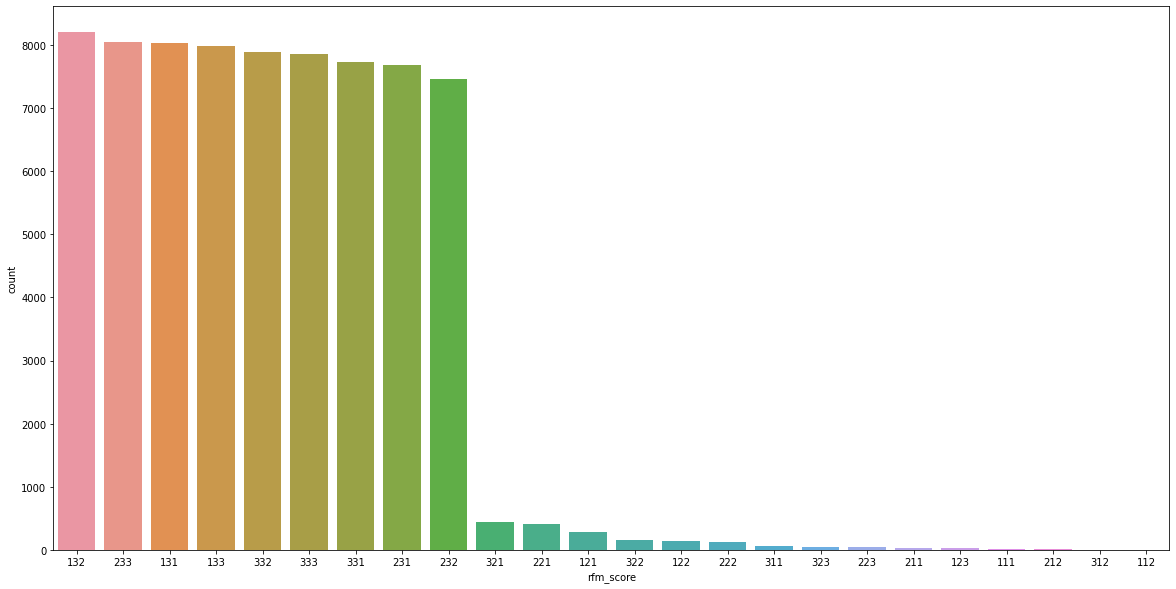

In [101]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df_rfm, x='rfm_score', order = df_rfm['rfm_score'].value_counts().index)

>ВЫВОД:
>Описание случайного пользователя `0000366f3b9a7992bf8c76cfdf3221e2`. RFM-сегмент 331 (recency=3, frequency=3, monetary=1), имеет границы метрик recency от 0 до 116 дней, имеет границы метрик frequency 1 заказ в год, имеет границы метрик monetary от 124.99 до 13440.0 рублей в год.